## Import Packages and Set Directories

In [96]:
# Import packages
import os
import sys
import warnings
import inspect
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from scipy.interpolate import make_interp_spline
from scipy.interpolate import UnivariateSpline
import statsmodels.api as sm

# Set directories
notebook_dir = os.getcwd()
base_dir = os.path.join(notebook_dir, '..')
data_dir = os.path.join(base_dir, 'data', 'processed')
raw_data_dir = os.path.join(base_dir, 'data', 'raw')
factor_dir = os.path.join(base_dir, 'data', 'processed', 'factors')
sample_dir = os.path.join(base_dir, 'data', 'processed', 'sample_stock')
src_dir = os.path.join(base_dir, 'src')
graph_dir = os.path.join(base_dir, 'results', 'graphs')
sys.path.append(src_dir)

# Import optimal portfolio
from optimal_portfolios import OptimalPortfolios

# Ignore future warning
warnings.simplefilter(action='ignore', category=FutureWarning)

## Read in Data

In [241]:
df = pd.read_csv(os.path.join(data_dir, 'covariates_weekly.csv'))
df.drop(columns=['IA', 'ME'], inplace=True)  # IA is equivalent to CMA, ME is equivalent to SMB
display(df)

,Phase,Year_Week,R1-RF,R2-RF,R3-RF,R4-RF,R5-RF,CMA,CRD,EG,HML,LIQ,MOM,Mkt-RF,RMW,ROE,SMB
0,Recovery,1991-14,0.064083,0.151665,0.240093,0.351809,0.486501,-0.570730,1.150221,-0.5419,-0.869560,1.472018,0.891933,0.513137,-0.032457,0.4557,1.521326
1,Recovery,1991-15,0.264305,0.446745,0.625524,0.810416,0.994500,0.621385,2.298820,0.2974,0.269460,1.155684,0.530151,1.069284,-0.160184,1.1641,-0.205230
2,Recovery,1991-16,0.397411,0.619196,0.907172,1.230816,1.589712,0.369853,-0.318141,0.1628,1.181054,0.726344,-2.540450,0.823179,0.438583,-0.9019,-0.383025
3,Recovery,1991-17,-0.461241,-0.385072,-0.400580,-0.428202,-0.403049,-0.120218,-1.594360,0.7819,0.109392,-1.943223,-0.758405,-1.507046,0.410131,0.1809,-0.043628
4,Recovery,1991-18,0.821113,1.138815,1.524840,1.898956,2.274717,0.149088,-0.747710,-0.9039,0.358368,-1.789523,0.498412,0.284198,0.149900,0.3691,-0.427979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723,Depression,2023-13,4.144311,4.268809,4.386330,4.489266,4.585168,-0.485292,-1.407705,-1.4244,-0.143893,1.732601,-0.973392,3.558954,-1.316858,-0.8488,0.034930
1724,Depression,2023-14,-1.481199,-1.531586,-1.575233,-1.613650,-1.644906,1.735561,-1.614857,0.5352,0.917433,-1.772066,-0.320548,-0.503105,0.888682,-0.5042,-2.343848
1725,Depression,2023-15,0.767495,1.030717,1.232677,1.425500,1.621474,-0.173153,1.298617,-0.7802,0.240468,0.917606,1.088540,0.902690,0.870444,0.6098,0.521296
1726,Depression,2023-16,0.158554,0.149252,0.127413,0.088726,0.046188,0.429173,1.073625,-0.5350,-1.267848,-0.700302,1.692891,-0.202255,-1.235283,-1.8503,0.769253


## 1. Stepwise and Best Subset Selection

### 1.1 Define Functions

In [291]:
def forward_selection(X, y, criterion='aic', verbose=True):
    """ Perform forward feature selection based on AIC or BIC
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        criterion - 'aic' or 'bic' as the criterion for feature selection
        verbose - whether to print the sequence of inclusions
    Returns: tuple of (list of selected features, best model)
    """
    included = []
    current_score = float('inf')
    best_model = None

    while True:
        changed = False
        excluded = list(set(X.columns) - set(included))
        new_score = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(X[included + [new_column]])).fit()
            new_score[new_column] = model.aic if criterion == 'aic' else model.bic
        best_score = new_score.min()
        if new_score is not None and (len(included) == 0 or best_score < current_score):
            best_feature = new_score.idxmin()
            included.append(best_feature)
            current_score = best_score                        
            changed = True
            if verbose:
                print('Add  {:10} with {} {:.6}'.format(best_feature, criterion.upper(), best_score))
        if not changed:
            best_model = sm.OLS(y, sm.add_constant(X[included])).fit()
            break

    return included, best_model


def best_subset_selection(X, y, criterion='aic'):
    """ Perform best subset selection based on AIC or BIC
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        criterion - 'aic' or 'bic' for the selection criterion
    Returns: tuple of (best model, best features)
    """
    best_score = float('inf')
    best_model = None
    best_features = None

    # Iterate over all possible combinations of predictors
    for k in range(1, len(X.columns) + 1):
        for subset in itertools.combinations(X.columns, k):
            X_subset = sm.add_constant(X[list(subset)])
            model = sm.OLS(y, X_subset).fit()
            score = model.aic if criterion == 'aic' else model.bic
            if score < best_score:
                best_score = score
                best_model = model
                best_features = subset

    return best_features, best_model


def get_data(df, phase):
    df_phase = df[df['Phase']==phase].copy()    
    # Filter out covariates
    X_cols = df_phase.columns.difference(['Phase', 'Year_Week', 'R1-RF', 'R2-RF', 'R3-RF', 'R4-RF', 'R5-RF'])
    X = df_phase[X_cols].reset_index(drop=True)
    # Use portfolio 3, 4 and 5 for depression. See optimal_portfolio_creation.ipynb for reason
    if phase == 'Depression':
        Y = df_phase[['R3-RF', 'R4-RF', 'R5-RF']].reset_index(drop=True)
    else:
        Y = df_phase[['R1-RF', 'R3-RF', 'R5-RF']].reset_index(drop=True)
    return X, Y

def get_feature_names(dict_in_list):
    feature_names = set()
    for phase_dict in best_list:
        for features in phase_dict.values():
            feature_names.update(features)
    feature_names = list(feature_names)
    return feature_names

### 1.2 Run Forward Selection and Best Subset Selection

In [292]:
# Forward selection
num_pfos = 3
phases = ['Recovery', 'Expansion', 'Downturn', 'Depression']
forward_selected = {}  # Store the dictionary of features for each phase
forward_models = {}

# Loop over phases
for phase in phases:    
    X, Y = get_data(df, phase)
    # Loop over portfolios
    for p in range(num_pfos):
        y = Y.iloc[:, p]
        # Forward selection
        forward_features, fowrward_model = forward_selection(X, y, verbose=False) 
        # Add the selected list of features to dictionary
        phase_pfo = phase + '_' + str(p+1)
        forward_selected[phase_pfo] = sorted(forward_features)
        forward_models[phase_pfo] = fowrward_model
    
display(forward_selected)

{'Recovery_1': ['CMA', 'LIQ', 'Mkt-RF', 'SMB'],
 'Recovery_2': ['CMA', 'LIQ', 'Mkt-RF', 'SMB'],
 'Recovery_3': ['CMA', 'LIQ', 'Mkt-RF', 'SMB'],
 'Expansion_1': ['CRD', 'EG', 'HML', 'MOM', 'Mkt-RF', 'RMW', 'SMB'],
 'Expansion_2': ['EG', 'HML', 'LIQ', 'Mkt-RF', 'RMW', 'ROE', 'SMB'],
 'Expansion_3': ['CMA', 'EG', 'HML', 'LIQ', 'Mkt-RF', 'RMW', 'SMB'],
 'Downturn_1': ['CMA', 'CRD', 'HML', 'LIQ', 'Mkt-RF', 'RMW', 'SMB'],
 'Downturn_2': ['CMA', 'CRD', 'HML', 'LIQ', 'MOM', 'Mkt-RF', 'RMW', 'SMB'],
 'Downturn_3': ['CMA', 'LIQ', 'MOM', 'Mkt-RF', 'RMW', 'SMB'],
 'Depression_1': ['CMA', 'EG', 'LIQ', 'Mkt-RF', 'RMW', 'ROE', 'SMB'],
 'Depression_2': ['EG', 'LIQ', 'Mkt-RF', 'RMW', 'ROE', 'SMB'],
 'Depression_3': ['EG', 'LIQ', 'Mkt-RF', 'RMW', 'ROE', 'SMB']}

In [293]:
# Best subset selection (this might take a while)
num_pfos = 3
phases = ['Recovery', 'Expansion', 'Downturn', 'Depression']
best_selected = {}  # Store the dictionary of features for each phase
best_models = {}

# Loop over phases
for phase in phases:
    X, Y = get_data(df, phase)
    # Loop over portfolios
    for p in range(num_pfos):
        y = Y.iloc[:, p]
        # Best subset selection
        best_features, best_model = best_subset_selection(X, y) 
        # Add the selected list of features to dictionary
        phase_pfo = phase + '_' + str(p+1)
        best_selected[phase_pfo] = sorted(list(best_features))
        best_models[phase_pfo] = best_model

display(best_selected)

{'Recovery_1': ['CMA', 'CRD', 'EG', 'LIQ', 'Mkt-RF', 'RMW', 'ROE', 'SMB'],
 'Recovery_2': ['CMA', 'EG', 'LIQ', 'Mkt-RF', 'RMW', 'ROE', 'SMB'],
 'Recovery_3': ['CMA', 'EG', 'LIQ', 'Mkt-RF', 'ROE', 'SMB'],
 'Expansion_1': ['CRD', 'EG', 'HML', 'MOM', 'Mkt-RF', 'RMW', 'SMB'],
 'Expansion_2': ['EG', 'HML', 'LIQ', 'Mkt-RF', 'RMW', 'ROE', 'SMB'],
 'Expansion_3': ['CMA', 'EG', 'HML', 'LIQ', 'Mkt-RF', 'RMW', 'SMB'],
 'Downturn_1': ['CMA', 'CRD', 'HML', 'LIQ', 'Mkt-RF', 'RMW', 'SMB'],
 'Downturn_2': ['CMA', 'CRD', 'HML', 'LIQ', 'MOM', 'Mkt-RF', 'RMW', 'SMB'],
 'Downturn_3': ['CMA', 'LIQ', 'MOM', 'Mkt-RF', 'RMW', 'SMB'],
 'Depression_1': ['CMA', 'EG', 'LIQ', 'Mkt-RF', 'RMW', 'ROE', 'SMB'],
 'Depression_2': ['EG', 'LIQ', 'Mkt-RF', 'RMW', 'ROE', 'SMB'],
 'Depression_3': ['EG', 'LIQ', 'Mkt-RF', 'RMW', 'ROE', 'SMB']}

### 1.3 Show Results for Selected Features

In [294]:
def plot_feature_selection(feature_list, title, save_path=None):        
    # Flatten the data and create a DataFrame for plotting
    feature_names = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM', 'EG', 'ROE', 'CRD', 'LIQ']
    flattened_data = {}
    for phase, features in feature_list.items():
        for feature in feature_names:
            flattened_data.setdefault(phase, []).append(feature in features)
    df_plot = pd.DataFrame(flattened_data, index=feature_names)
    
    plt.figure(figsize=(5, 4))
    ax = plt.gca()
    # Create a color matrix corresponding to the data values
    color_map = {'Recovery': 'olivedrab', 'Expansion': 'tomato', 'Downturn': 'steelblue', 'Depression': 'firebrick'}
    color_matrix = np.zeros((len(df_plot.index), len(df_plot.columns), 4))
    for col_idx, col in enumerate(df_plot.columns):
        phase_color = color_map[col.split('_')[0]]
        for row_idx, value in enumerate(df_plot[col]):
            if value:
                color_matrix[row_idx, col_idx] = mcolors.to_rgba(phase_color)
            else:
                color_matrix[row_idx, col_idx] = mcolors.to_rgba('white')
    ax.imshow(color_matrix, aspect='auto')

    # Setting up grid lines for separation
    ax.set_xticks(np.arange(len(df_plot.columns))-0.5, minor=True)
    ax.set_yticks(np.arange(len(df_plot.index))-0.5, minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=1)
    ax.tick_params(which="minor", size=0)
    ax.tick_params(axis='x', which='major', length=0)
    new_x_labels = ['Low', 'Mid', 'High'] * 4

    # Setting x and y ticks with new labels and smaller font size
    plt.tick_params(axis='x', top=True, bottom=False, labeltop=True, labelbottom=False, labelsize=8)
    plt.xticks(ticks=np.arange(len(df_plot.columns)), labels=new_x_labels)
    plt.yticks(ticks=np.arange(len(df_plot.index)), labels=df_plot.index, fontsize=8)

    # Add legend with smaller font size
    legend_elements = [Patch(facecolor=color, label=phase) for phase, color in color_map.items()]
    ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=len(color_map), fontsize=8)
    plt.title(title, pad=30, fontsize=10)
    plt.tight_layout()
    if save_path:
        plt.savefig(os.path.join(graph_dir, save_path), bbox_inches='tight')
    else:
        plt.show()

def create_coef_df(model_dict, num_pfo=3):
    # Create dataframe that shows coefficients of the best model
    phases = ['Recovery', 'Expansion', 'Downturn', 'Depression']
    start = True
    for phase in phases:
        for p in range(num_pfo):
            pfo_str = phase + '_' + str(p+1)
            df_tmp = pd.DataFrame(model_dict[pfo_str].params)
            df_tmp.columns = [pfo_str]
            if start:
                best_coefficients = df_tmp
                start = False
            else:
                best_coefficients = pd.concat([best_coefficients, df_tmp], axis=1)

    # Set the order of index
    order = ['const', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM', 'EG', 'ROE', 'CRD', 'LIQ']        
    best_coefficients = np.round(best_coefficients.reindex(order), 4)
    return best_coefficients

Plot forward selection selected features

,Recovery_1,Recovery_2,Recovery_3,Expansion_1,Expansion_2,Expansion_3,Downturn_1,Downturn_2,Downturn_3,Depression_1,Depression_2,Depression_3
const,0.2122,0.4535,0.6752,0.1022,0.2476,0.3807,0.1361,0.2786,0.4159,0.3008,0.3680,0.4324
Mkt-RF,0.6160,0.6393,0.6719,0.7992,0.8434,0.8967,0.6597,0.7116,0.7873,0.9171,0.9070,0.9013
SMB,0.1658,0.1917,0.2264,0.3203,0.3521,0.3925,0.1009,0.1167,0.1713,0.4594,0.4635,0.4590
HML,NaN,NaN,NaN,0.2609,0.2666,0.3041,-0.1000,-0.0718,NaN,NaN,NaN,NaN
RMW,NaN,NaN,NaN,0.3186,0.3669,0.2637,0.2118,0.2246,0.2017,0.2990,0.3176,0.2795
CMA,0.2433,0.2247,0.2076,NaN,NaN,-0.1133,0.2112,0.1777,0.1007,0.1127,NaN,NaN
MOM,NaN,NaN,NaN,-0.0566,NaN,NaN,NaN,0.0588,0.1005,NaN,NaN,NaN
EG,NaN,NaN,NaN,0.0932,0.1721,0.2525,NaN,NaN,NaN,-0.3172,-0.3463,-0.3544
ROE,NaN,NaN,NaN,NaN,-0.0920,NaN,NaN,NaN,NaN,0.2328,0.2829,0.3304
CRD,NaN,NaN,NaN,-0.0526,NaN,NaN,-0.0909,-0.0588,NaN,NaN,NaN,NaN


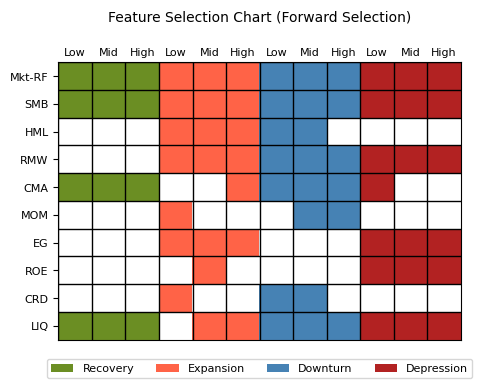

In [295]:
# Plot forward selection
title = 'Feature Selection Chart (Forward Selection)'
save_path = 'forward_selection_chart.png'
plot_feature_selection(forward_selected, title, save_path)

# Show forward selection coefficients
forward_coef = create_coef_df(forward_models)
display(forward_coef)

Plot best subset selected features

,Recovery_1,Recovery_2,Recovery_3,Expansion_1,Expansion_2,Expansion_3,Downturn_1,Downturn_2,Downturn_3,Depression_1,Depression_2,Depression_3
const,0.2388,0.4739,0.6871,0.1022,0.2476,0.3807,0.1361,0.2786,0.4159,0.3008,0.3680,0.4324
Mkt-RF,0.6330,0.6535,0.6839,0.7992,0.8434,0.8967,0.6597,0.7116,0.7873,0.9171,0.9070,0.9013
SMB,0.1612,0.1813,0.2208,0.3203,0.3521,0.3925,0.1009,0.1167,0.1713,0.4594,0.4635,0.4590
HML,NaN,NaN,NaN,0.2609,0.2666,0.3041,-0.1000,-0.0718,NaN,NaN,NaN,NaN
RMW,-0.1288,-0.0940,NaN,0.3186,0.3669,0.2637,0.2118,0.2246,0.2017,0.2990,0.3176,0.2795
CMA,0.2284,0.2242,0.1598,NaN,NaN,-0.1133,0.2112,0.1777,0.1007,0.1127,NaN,NaN
MOM,NaN,NaN,NaN,-0.0566,NaN,NaN,NaN,0.0588,0.1005,NaN,NaN,NaN
EG,-0.0945,-0.1439,-0.1588,0.0932,0.1721,0.2525,NaN,NaN,NaN,-0.3172,-0.3463,-0.3544
ROE,0.1789,0.1507,0.1234,NaN,-0.0920,NaN,NaN,NaN,NaN,0.2328,0.2829,0.3304
CRD,-0.0448,NaN,NaN,-0.0526,NaN,NaN,-0.0909,-0.0588,NaN,NaN,NaN,NaN


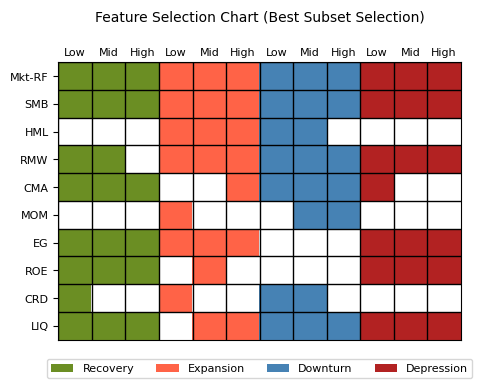

In [296]:
# Plot best subset selection
title = 'Feature Selection Chart (Best Subset Selection)'
save_path = 'bestsubset_selection_chart.png'
plot_feature_selection(best_selected, title, save_path)

# Show forward selection coefficients
best_coef = create_coef_df(best_models)
display(best_coef)

## 2. Lasso Regression

## 3. Adding Principal Components

## 4. Check Overfitting